# Pre-requisits
- "Models training helpers.ipynb should be contained in the same directory as this file
    in order to run command %run "Models training helpers.ipynb" sort=False and utilize the helpers
- Glove should be downloaded to 'Data/Iterative-models-building/Training data/glove.6B.100d.t
    this is where Models training helpers.ipynb will pick it up   


<h1>Iterative Model Building - Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-requisits" data-toc-modified-id="Pre-requisits-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-requisits</a></span></li><li><span><a href="#Import-&quot;Models-training-helpers.ipynb-and-3-helper-classes." data-toc-modified-id="Import-&quot;Models-training-helpers.ipynb-and-3-helper-classes.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import "Models training helpers.ipynb and 3 helper classes.</a></span></li><li><span><a href="#Setup-Github-credentials-to-be-used-for-reading-data-and-in-some-cases-pushing-data-directly-to-github" data-toc-modified-id="Setup-Github-credentials-to-be-used-for-reading-data-and-in-some-cases-pushing-data-directly-to-github-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Setup Github credentials to be used for reading data and in some cases pushing data directly to github</a></span></li><li><span><a href="#Data-gathering" data-toc-modified-id="Data-gathering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data gathering</a></span></li><li><span><a href="#Clasification---load-the-classifiers-from-pickle-files" data-toc-modified-id="Clasification---load-the-classifiers-from-pickle-files-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Clasification - load the classifiers from pickle files</a></span></li><li><span><a href="#Pass-all-the-combined-convention-sentences-through-each-convention-classifier." data-toc-modified-id="Pass-all-the-combined-convention-sentences-through-each-convention-classifier.-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Pass all the combined convention sentences through each convention classifier.</a></span></li><li><span><a href="#Annotate-data-for-each-type-of-classifications-(high-confidence,-medium,-low-+-the-confidence-score)---Not-currently-in-use" data-toc-modified-id="Annotate-data-for-each-type-of-classifications-(high-confidence,-medium,-low-+-the-confidence-score)---Not-currently-in-use-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Annotate data for each type of classifications (high confidence, medium, low + the confidence score) - Not currently in use</a></span></li><li><span><a href="#Add-a-column-&quot;confidence-level&quot;,--to-the-classified-sentences-per-convention,-based-on-the-value-of-confidence-score" data-toc-modified-id="Add-a-column-&quot;confidence-level&quot;,--to-the-classified-sentences-per-convention,-based-on-the-value-of-confidence-score-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Add a column "confidence level",  to the classified sentences per convention, based on the value of confidence score</a></span></li><li><span><a href="#Store-conventions-classification-results-to-the-following-location:" data-toc-modified-id="Store-conventions-classification-results-to-the-following-location:-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Store conventions classification results to the following location:</a></span></li><li><span><a href="#Create-the-aggregated-dataframe-of-the-classified-&quot;Gathered_data&quot;-to-then-used-by-the-audit-tool-to-obtain-more-training-data" data-toc-modified-id="Create-the-aggregated-dataframe-of-the-classified-&quot;Gathered_data&quot;-to-then-used-by-the-audit-tool-to-obtain-more-training-data-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Create the aggregated dataframe of the classified "Gathered_data" to then used by the audit tool to obtain more training data</a></span></li><li><span><a href="#Next-steps-to-be-done-manually-via-the-audit-tool,-which-will-created-audit-files-at-location-AUDITED_DATA_DIR_GIT" data-toc-modified-id="Next-steps-to-be-done-manually-via-the-audit-tool,-which-will-created-audit-files-at-location-AUDITED_DATA_DIR_GIT-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Next steps to be done manually via the audit tool, which will created audit files at location AUDITED_DATA_DIR_GIT</a></span></li><li><span><a href="#Collect-Audited-Data-for-purpose-of-retraining." data-toc-modified-id="Collect-Audited-Data-for-purpose-of-retraining.-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Collect Audited Data for purpose of retraining.</a></span></li><li><span><a href="#Retrain-the-models-with-the-new-audited-data-and-training-data" data-toc-modified-id="Retrain-the-models-with-the-new-audited-data-and-training-data-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Retrain the models with the new audited data and training data</a></span></li><li><span><a href="#Get-Stopwords" data-toc-modified-id="Get-Stopwords-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Get Stopwords</a></span></li></ul></div>

# Import "Models training helpers.ipynb and 3 helper classes. 


In [275]:
%run "All_helper_classes.ipynb" sort=False

#from "Models training helpers.ipynb" we will import 3 helper classes and the associated helper methods.
parsing_helpers = generic_parsing_helpers()
aivm_helper = AIVM_helper()
model_helpers = default_model_helpers_for_project()
paths = project_paths()
#Get the latest version of the aggregated already audited data (output from the audit tool) directly from GIT



Necessary libraries imported.
Initialised generic_parsing_helpers class and methods
Initialised AIVM_helper class and methods
Initialised model_helpers class and methods


In [ ]:
%%javascript
//To remove scroll from any output area and automatically extend the jupyter cell
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

# Setup Github credentials to be used for reading data and in some cases pushing data directly to github

*****Rember to add your github user and passeord here*******

In [ ]:
#To read all the data files directly from  github
USE_GIT_HUB = True 



#########To push data files directly to  github - usr/pssword required######
GIT_USER = 'aideenf' 
GIT_PSWD = 'aid99rk4'
###*******END-POPULATE GIT_HUB Credentials ********#########################

# Data gathering

To be done for different sources, to have high variability. It's important to keep tracking of where does each sentence come from (add a label of provenance).
Identified data sources:
    - Google
    - Github
    - Semantic Scholar
    - pdf files

In [135]:
USE_GIT_HUB = True  #Use github directly to read the training data and gathered data

# Read the gathered_data files "paths.TRAINING_DATA_DIR_FILE" with column_to_clean = 'text' and return 
# a pandas Data Frame
gathered_conventions_files, gathered_conventions_df = model_helpers.get_aggregated_gathered_data (
                            USE_GIT_HUB,
                            paths.GATHERED_DATA_CONV_DIR_GIT,
                            paths.GATHERED_DATA_CONV_DIR_LOCAL,
                            paths.GITHUB_GATHERED_URL_PATH, 
                            paths.GIT_OWNER,
                            paths.GIT_REPO)

display ("Now we have a dictionary(gathered_conventions_data) of dataframes one entry for each gathered sentence source:" , gathered_conventions_files)
display (gathered_conventions_df.head(5))

Initialised AIVM_helper class and methods


# Clasification - load the classifiers from pickle files

Classify, using each of the classifiers, the gathered sentences
Right now the pickle files are always read from the local machine as they are not compressed and are too big to store on gitHub. it will be convenient if we either
    - push to another centralized location automatically on creation
    
in order to avoid the need for manual synchronization. Note that the code to read from cloud is partially implemented. see below! 

In [281]:
## Read pickled classifiers https://www.thoughtco.com/using-pickle-to-save-objects-2813661
# Note: pickle is used for serializing and de-serializing a Python object structure. 
# Any object in python can be pickled so that it can be saved on disk. 
# What pickle does is that it “serialises” the object first before writing it to file. 
# Pickling is a way to convert a python object (list, dict, etc.) into a character stream
## read convention models from pickle file from gitHub or local  (NOTE: this is in GIT)
USE_GIT_HUB = True
if(USE_GIT_HUB == True): 
     
    #make sure updated pickle files are in github
     _conventions_models, _conventions_tokenizers, _conventions_data_val_x ,_conventions_data_val_y ,_conventions_train_histories = model_helpers.read_DL_models_from_pickle(True, paths.CONV_MODEL_PCKL_URL, paths.MODELS_DIR_LOCAL)
   
    
elif(USE_GIT_HUB == False):
    ## Load the  convention models from the downloaded pickle file             
    _conventions_models, _conventions_tokenizers, _conventions_data_val_x ,_conventions_data_val_y ,_conventions_train_histories = model_helpers.read_DL_models_from_pickle(False, 'conv_models_items.pickle', paths.MODELS_DIR_LOCAL)

# Pass all the combined convention sentences through each convention classifier. 

In [282]:
data_sentences = gathered_conventions_df['text']
data_sentences_provenance = gathered_conventions_df['provenance']


conventions_classification = model_helpers.calculate_matches_DL( data_sentences, _conventions_models, _conventions_tokenizers)
display (conventions_classifications)
gc.collect()

{'training_Domestic.txt': array([0.49484226, 0.5286302 , 0.3985585 , ..., 0.01692784, 0.01085482,
        0.21079467], dtype=float32),
 'training_Civic.txt': array([0.04898009, 0.00690331, 0.0257176 , ..., 0.00725713, 0.00043306,
        0.01036146], dtype=float32),
 'training_Project.txt': array([8.4338385e-01, 2.3925945e-01, 7.5533372e-01, ..., 1.7265688e-01,
        8.0423959e-04, 9.7571075e-01], dtype=float32),
 'training_Inspired.txt': array([0.00118321, 0.32361186, 0.02998996, ..., 0.02082202, 0.2663042 ,
        0.00473872], dtype=float32),
 'training_Green.txt': array([0.00276766, 0.2844936 , 0.042117  , ..., 0.08290219, 0.01610001,
        0.01512012], dtype=float32),
 'training_Market.txt': array([1.6413704e-01, 1.4360935e-03, 2.6892603e-04, ..., 7.1194448e-04,
        1.2051293e-02, 1.0864363e-05], dtype=float32),
 'training_Industrial.txt': array([0.7737953 , 0.18235698, 0.05561984, ..., 0.37716824, 0.99817514,
        0.9960849 ], dtype=float32),
 'training_Renown.txt': ar

7

# Annotate data for each type of classifications (high confidence, medium, low + the confidence score) - Not currently in use

In [298]:
class ClassificationResult:
        
    def __init__(self, text, value, level, provenance='Unknown'):
        self.text = text
        self.confidence_value = value
        self.confidence_level = level
        self.data_provenance = provenance
        
    def __str__(self):
        return "{} -- {} -- {}".format(self.text, self.confidence_value, self.confidence_level)
    
    def __repr__(self):
        return "{} -- {} -- {}".format(self.text, self.confidence_value, self.confidence_level)
        
        
def split_sentences_by_confidence (calculated_classifications, _sentences, _sentences_provenance):

    stratified_classifications = {}

    for k in calculated_classifications.keys():
        classifications = calculated_classifications[k]
        display (classifications)
        ## Low level percentile eg 33
        low_percentile = np.percentile(classifications, 33)#0.2
        classifications_low = np.where(classifications<=low_percentile)[0]
        print(classifications_low)

        ## Medium level percentile
        medium_percentile = np.percentile(classifications, 66)#0.8
        classifications_medium = np.where((classifications<=medium_percentile) & (classifications>low_percentile))[0]
        #print(classifications_medium)

        ## High level percentile
        top_percentile = np.percentile(classifications, 100) #1.0
        classifications_top = np.where((classifications<=top_percentile) & (classifications>medium_percentile))[0]
        #print(classifications_top)
       
        classified_sentences = []
        print(classifications_low)
        for i1 in classifications_low:
            c1 = ClassificationResult(_sentences[i1], classifications[i1], "Low", _sentences_provenance[i1])
            classified_sentences.append(c1)

        for i2 in classifications_medium:
            c2 = ClassificationResult(_sentences[i2], classifications[i2], "Medium", _sentences_provenance[i2])
            classified_sentences.append(c2)

        for i3 in classifications_top:
            c3 = ClassificationResult(_sentences[i3], classifications[i3], "High", _sentences_provenance[i3])
            classified_sentences.append(c3)
            
        stratified_classifications[aivm_helper.clean_file_name(k)] = classified_sentences
    return stratified_classifications

# Add a column "confidence level",  to the classified sentences per convention, based on the value of confidence score

Not currently used as we do not need the confidence level for the audit tool, only the confidence score

In [300]:
#conv_stratified_classifications = split_sentences_by_confidence(conventions_classifications, data_sentences, data_sentences_provenance)

# Store conventions classification results to the following location:
* paths.CLASSIFIED_DATA_DIR_LOCAL 
* paths.CLASSIFIED_DATA_DIR_GIT directly to git if this option is activated.

in format "results_{convention}_.tsv"

A conventions_classifications list exists per convention and contains the probability that the sentence was classified as 1, for each model for each sentence. 
so we have:
    * conventions_classifications (score per model per sentence from gathered_data)
    * data_sentences  (list of sentences from gathered_dat)
    * data_sentences_provenance (list of provenance from gathered_data)
    
 We will use this data to create one results file per convention and store to
 
paths.CLASSIFIED_DATA_DIR_LOCAL: ./Data/Iterative-models-building/Classification results/Conventions/
paths.CLASSIFIED_DATA_DIR_GIT: cp_wssc/Data/Iterative-models-building/Classification results/Conventions/

In [ ]:
#conventions_classifications  for scenario where the split_sentences_by_confidence method was previously called.
def create_classified_files_with_conf_level (conv_stratified_classifications, data_sentences,data_sentences_provenance ):
    file_list = []
    file_list_git = []
  
    for k in conv_stratified_classifications.keys():
        file_name = k.replace("training_", "")
        file_name = file_name.replace(".txt", "")
        # if we do not want the "training in the name" k.replace("training_", "").lower()
        with open(os.path.join(paths.CLASSIFIED_DATA_DIR_LOCAL, "{}_.tsv".format(file_name)), "w")as f3:
        
            file_list.append(paths.CLASSIFIED_DATA_DIR_LOCAL + "{}_.tsv".format(file_name))
            file_list_git.append(paths.CLASSIFIED_DATA_DIR_GIT + "{}_.tsv".format(file_name))
        
            f3.write("{}\t{}\t{}\t{}\t{}\n".format("text", "convention", "confidence_value", "confidence_level", "data_provenance"))
    
            for c in conv_stratified_classifications[k]:
                convention = k.replace("training_", "").lower()     
                f3.write("{}\t{}\t{}\t{}\t{}\n".format(c.text, convention, c.confidence_value, c.confidence_level, c.data_provenance))
            f3.close()
    return file_list, file_list_git   
    gc.collect()
    
    
#conventions_classifications exists per convention and contains the probability that the sentence was classified as 1
#for each model for each sentence
def create_classified_files (conventions_classifications, data_sentences, data_sentences_provenance, dir_local, dir_git):
    
    file_list = []
    file_list_git = []
    print("saving files to :",dir_local)
    for k in conventions_classifications.keys():
        file_name = k.replace("training_", "")
        file_name = file_name.replace(".txt", "")
        # if we do not want the "training in the name" k.replace("training_", "").lower()
        with open(os.path.join(dir_local, "results_{}.tsv".format(file_name)), "w")as f3:
        
            file_list.append(dir_local + "results_{}.tsv".format(file_name))
            file_list_git.append(dir_git + "results_{}.tsv".format(file_name))
        
            f3.write("{}\t{}\t{}\t{}\n".format("text", "convention", "confidence_value", "data_provenance"))
    
            for cc, ds, dsp in zip(conventions_classifications[k], data_sentences, data_sentences_provenance ):
                convention = k.replace("training_", "").lower()     
                f3.write("{}\t{}\t{}\t{}\n".format(ds, convention, cc, dsp))
            f3.close()
    return file_list, file_list_git
        
    gc.collect()



In [345]:

file_list_classified, file_list_classified_git = create_classified_files (conventions_classifications, 
                                                                         data_sentences, 
                                                                         data_sentences_provenance,
                                                                         paths.CLASSIFIED_DATA_DIR_LOCAL,
                                                                         paths.CLASSIFIED_DATA_DIR_GIT)

saving files to : ./Data/Iterative-models-building/Classification results/Conventions/


In [346]:
def save_results_to_git(file_list_classified, file_list_classified_git, git_user, git_pswd, git_owner_repo):
    
    #push to github
    my_file_list = file_list_classified
    push_to_git_as = file_list_classified_git
    commit, message = aivm_helper.save_to_github(git_user, git_pswd, git_owner_repo, my_file_list, push_to_git_as, "auto push classified conventions")

    if (commit != "error"):
        print ("File to commit:", my_file_list)
        print ("Push to git as:", push_to_git_as)
        print ("Commit: ", commit)
        display(HTML("<font color='green'><b>Files Merged and Saved!!</b></font>"))
        
            
    if (commit == "error"):
        print ("File to commit: ", my_file_list)
        print ("Push to git as: ", push_to_git_as)
        display(HTML("<font color='red'><b>Warning!!</b></font>"))
        print(message)
    return file_list_classified

In [347]:
USE_GIT_HUB = True
save_results_to_git(file_list_classified, file_list_classified_git, GIT_USER, GIT_PSWD, paths.GIT_OWNER_REPO)

commit GitCommit(sha="d18642871fb31ba64025702d697c60bd8d8a7ddc")
File to commit: ['./Data/Iterative-models-building/Classification results/Conventions/results_Domestic.tsv', './Data/Iterative-models-building/Classification results/Conventions/results_Civic.tsv', './Data/Iterative-models-building/Classification results/Conventions/results_Project.tsv', './Data/Iterative-models-building/Classification results/Conventions/results_Inspired.tsv', './Data/Iterative-models-building/Classification results/Conventions/results_Green.tsv', './Data/Iterative-models-building/Classification results/Conventions/results_Market.tsv', './Data/Iterative-models-building/Classification results/Conventions/results_Industrial.tsv', './Data/Iterative-models-building/Classification results/Conventions/results_Renown.tsv']
Push to git as: ['cp_wssc/Data/Iterative-models-building/Classification results/Conventions/results_Domestic.tsv', 'cp_wssc/Data/Iterative-models-building/Classification results/Conventions/r

# Create the aggregated dataframe of the classified "Gathered_data" to then used by the audit tool to obtain more training data

In [349]:
print (file_list_classified)

['./Data/Iterative-models-building/Classification results/Conventions/results_Domestic.tsv', './Data/Iterative-models-building/Classification results/Conventions/results_Civic.tsv', './Data/Iterative-models-building/Classification results/Conventions/results_Project.tsv', './Data/Iterative-models-building/Classification results/Conventions/results_Inspired.tsv', './Data/Iterative-models-building/Classification results/Conventions/results_Green.tsv', './Data/Iterative-models-building/Classification results/Conventions/results_Market.tsv', './Data/Iterative-models-building/Classification results/Conventions/results_Industrial.tsv', './Data/Iterative-models-building/Classification results/Conventions/results_Renown.tsv']


In [ ]:
#Create an aggregated DataFrame and then a tsv/csv file of the full data for auditing
#This code is to create a file and push it to git hub to be read by the audit tool only
# This is independant piece of code, removing it will only remove this functionality
# leaving it here means that when we retrain the model this file will be auto updated with
# new labels. (to discuss with David - to revert this to the format that can be used by the 
# model training process)
def create_toAudit_data_in_git(file_list_classified, GIT_USER, GIT_PSWD, paths.GIT_OWNER_REPO, paths.CLASSIFIED_DATA_DIR_LOCAL, paths.CLASSIFIED_DATA_DIR_GIT )
    file_list = file_list_classified
    df_list = [pd.read_csv(file, sep='\t') for file in file_list]
    #concatenate them 
    print("Concatenate all files to one")
    convention_sentences_df = pd.concat(df_list)
    ## We will perform one hot encoding
    print("Applying one hot encoding to convention to have format suitable for audit tool (binary and for all)")
    convention_sentences_df["convention"] = pd.Categorical(convention_sentences_df["convention"])
    dfDummies = pd.get_dummies(convention_sentences_df["convention"], prefix="convention")
    convention_sentences_df = pd.concat([convention_sentences_df, dfDummies], axis=1)
    convention_sentences_df = convention_sentences_df.drop(["convention"], axis=1)

    ## Now we will save a file 'audit_training_data.tsv'  and zipped version locally which contains all of the results
    file_name = 'audit_training_data.tsv'
    file_name_zip = 'audit_training_data.gz'

    convention_sentences_df.to_csv(paths.CLASSIFIED_DATA_DIR_LOCAL + file_name)
    convention_sentences_df.to_csv(paths.CLASSIFIED_DATA_DIR_LOCAL + file_name_zip, compression='gzip')

    ## We will also push this to git hub for use by audit tool
    if(USE_GIT_HUB == False):
        #Call helper file to zip the file for push to github
        my_file_list = [paths.CLASSIFIED_DATA_DIR_LOCAL + file_name_zip]
        push_to_git_as = [paths.CLASSIFIED_DATA_DIR_GIT +file_name_zip]

        commit, message = aivm_helper.save_to_github(GIT_USER, GIT_PSWD, paths.GIT_OWNER_REPO, my_file_list, push_to_git_as, "auto push for audit")

        if (commit != "error"):
            print ("File to commit:", my_file_list[0])
            print ("Push to git as:", push_to_git_as[0])
            print ("Commit: ", commit)
            display(HTML("<font color='green'><b>Files Merged and Saved!!</b></font>"))
        
            
        if (commit == "error"):
            print ("File to commit: ", my_file_list[0])
            print ("Push to git as: ", push_to_git_as[0])
            display(HTML("<font color='red'><b>Warning!!</b></font>"))
            print(message)


            
create_toAudit_data_in_git(file_list_classified, GIT_USER, GIT_PSWD, paths.GIT_OWNER_REPO, paths.CLASSIFIED_DATA_DIR_LOCAL, paths.CLASSIFIED_DATA_DIR_GIT )

In [ ]:
print(conv_stratified_classifications['training_Domestic'][0].text)
print(conv_stratified_classifications['training_Domestic'][1].text)

# Next steps to be done manually via the audit tool, which will created audit files at location AUDITED_DATA_DIR_GIT



Audit vai tool

filter via provrnance or convention

# Collect Audited Data for purpose of retraining. 
The files that have been produced by the audit tool are retrieved and consolodated into a data frame, this data frame is then converted to tsv file to produce one TSV file with all audited results.

This file will be called... 'audited_ALL_{date}-{time}.tsv' 

Any other process that wishes to use this file should look for the most recent 'audited_ALL_{date}-{time}.tsv'  or retrieve new version with this method

In [33]:
#Method to aggregate the audited data and to return a pandas DB containing the aggregated content. 
def aggregate_audited_data_from_git (audited_data_dir_git,
                            github_audit_url, 
                            audited_data_dir_local,
                            git_user, 
                            git_pswd, 
                            git_owner_repo,
                            git_owner,
                            git_repo) :

    audited_data_dir_git = audited_data_dir_git
    github_audit_url = github_audit_url
    audited_data_dir_local = audited_data_dir_local
    git_user = git_user
    git_pswd = git_pswd
    git_owner_repo = git_owner_repo
    git_owner = git_owner
    git_repo = git_repo

    # list all files from 'Audited' folder at cp_wssc/Data/Iterative-models-building/Classification%20results/Conventions/Audited/
    # Helper file call to Returns a list of files from the github owner, repo and dir_ref
    my_file_list = aivm_helper.list_files_from_github_dir (git_owner, git_repo, audited_data_dir_git)
    ## Helper file call to Remove our standard excluded files and all files that are not "audited_training_data"
    my_file_list = aivm_helper.remove_excluded_files_except(my_file_list, "audited_training_data")
    if (len(my_file_list) > 0):
        display (my_file_list.sort())
        #Returns a dataframe of concatinated files from github, of names from file_list from the github url specified.
        audited_df = aivm_helper.concat_files_from_github_dir (github_audit_url, my_file_list)
        date, time = aivm_helper.time_stamp()
        # file_name = 'audited_ALL_' + date + '-' + time + '.gz' # If using compression
        #df.to_csv(FILE_PATH + file_name, sep='\t', compression='gzip') # If using compression

        file_name = 'audited_ALL_' + date + '-' + time + '.tsv'
        file_name_unique = 'audited_ALL.tsv'
        
        audited_df.to_csv(audited_data_dir_local + file_name, sep='\t')

        #push to github
        my_file_list = [audited_data_dir_local + file_name, audited_data_dir_local + file_name]
        push_to_git_as = [audited_data_dir_git + file_name_unique, audited_data_dir_git + file_name]

        commit, message = aivm_helper.save_to_github(git_user, git_pswd, git_owner_repo, my_file_list, push_to_git_as, "auto push aggregated audit")

        if (commit != "error"):
            print ("File to commit:", my_file_list[0])
            print ("Push to git as:", push_to_git_as[0])
            print ("Commit: ", commit)
            display(HTML("<font color='green'><b>Files Merged and Saved!!</b></font>"))
        
            
        if (commit == "error"):
            print ("File to commit: ", my_file_list[0])
            print ("Push to git as: ", push_to_git_as[0])
            display(HTML("<font color='red'><b>Warning!!</b></font>"))
            print(message)
    
        return audited_df, message
    else:
        print ("*****NO FILES RETRIEVED******")
    gc.collect()
    
    



In [36]:
#Call the aggregate_audited_data method to have the aggregated data regenerated and a pandas data frame returned.
audited_df, message = aggregate_audited_data_from_git (paths.AUDITED_DATA_DIR_GIT,
                            paths.GITHUB_AUDIT_URL_PATH, 
                            paths.AUDITED_DATA_DIR_LOCAL,
                            GIT_USER, 
                            GIT_PSWD, 
                            GIT_OWNER_REPO,
                            GIT_OWNER,
                            GIT_REPO)

display (audited_df.head(5))
print (message)
print ("The number of audited samples is", audited_df.shape[0])


#Get the latest version of the aggregated already audited data (output from the audit tool) directly from GIT
audited_data_df = model_helpers.retrieve_aggregate_audited_data_from_git (paths.GITHUB_AGGREGATED_AUDIT_URL_FILE)


None

Got here  []
<class 'github.InputGitTreeElement.InputGitTreeElement'>
Got here  [<github.InputGitTreeElement.InputGitTreeElement object at 0x14440eb00>]
<class 'github.InputGitTreeElement.InputGitTreeElement'>
commit GitCommit(sha="4a3a482780098e4f390cbe738709b16c9ceab545")
File to commit: ./Data/Iterative-models-building/Classification results/Conventions/Audited/audited_ALL_2019-10-14-09:45:49.811247.tsv
Push to git as: cp_wssc/Data/Iterative-models-building/Classification results/Conventions/Audited/audited_ALL.tsv
Commit:  GitCommit(sha="4a3a482780098e4f390cbe738709b16c9ceab545")


,text,provenance,convention,old,new
0,"The system computes color, motion, and shape c...",Semantic Scholar,inspired,1,0
1,"To behave in a socially compliant way, robots ...",Semantic Scholar,inspired,1,0
2,Extraterrestrial drilling is an important samp...,Semantic Scholar,inspired,1,1
3,I am Srivatsan Srinivasan (I know!,Semantic Scholar,inspired,1,0
4,We demonstrate how the task priorities can be ...,Semantic Scholar,inspired,1,0


ok
The number of audited samples is 1404


# Retrain the models with the new audited data and training data - still to be reviewed

In [ ]:
# Read the already static training data file "paths.TRAINING_DATA_DIR_FILE" with column_to_clean = 'text' and return 
# a pandas Data Frame of training data
training_df = model_helpers.get_training_data(
                            USE_GIT_HUB,
                            paths.TRAINING_DATA_DIR_FILE_GIT,
                            paths.TRAINING_DATA_DIR_FILE_LOCAL, 
                            paths.GIT_OWNER,
                            paths.GIT_REPO)

In [105]:
def save_df_data_histogram(df, local, git, to_git, git_user, git_pswd, git_owner_repo):
    df = df
    git_user = git_user
    git_pswd = git_pswd
    git_owner_repo = git_owner_repo
    plot = df[['convention', 'new']].copy().rename(columns={"new": "Count"}).groupby('convention').count().plot(kind='bar', title="Audited per convention")  
   
    
    
    fig = plot.get_figure()
    fig.savefig(local + 'audited.png')
    
    if to_git == True:
        my_file_list = [local + 'audited.png']
        push_to_git_as = [git + 'audited.png']
    
        commit, message = aivm_helper.save_to_github(git_user, git_pswd, git_owner_repo, my_file_list, push_to_git_as, "auto push classified conventions")

        if (commit != "error"):
            print ("File to commit:", my_file_list)
            print ("Push to git as:", push_to_git_as)
            print ("Commit: ", commit)
            display(HTML("<font color='green'><b>Files Merged and Saved!!</b></font>"))
        
            
        if (commit == "error"):
            print ("File to commit: ", my_file_list)
            print ("Push to git as: ", push_to_git_as)
            display(HTML("<font color='red'><b>Warning!!</b></font>"))
            print(message)
    gc.collect()
    return plot

In [ ]:
# calling the last created aggregation of the audited data.
#Get the latest version of the aggregated already audited data (output from the audit tool) directly from GIT
audited_data_df = model_helpers.retrieve_aggregate_audited_data_from_git (paths.GITHUB_AGGREGATED_AUDIT_URL_FILE)


The number of audited samples is 1404
commit GitCommit(sha="694b640e1529d1b86dbcae37937654d78fd98ec2")
File to commit: ['./Data/Iterative-models-building/Classification results/Conventions/Audited/audited.png']
Push to git as: ['cp_wssc/Data/Iterative-models-building/Classification results/Conventions/Audited/audited.png']
Commit:  GitCommit(sha="694b640e1529d1b86dbcae37937654d78fd98ec2")


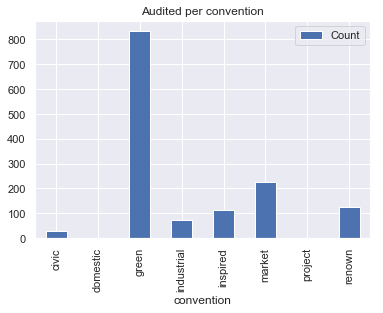

In [109]:
print ("The number of audited samples is", audited_df.shape[0])
plot = save_audited_data_histogram(audited_df, 
                            paths.AUDITED_DATA_DIR_LOCAL, 
                            paths.AUDITED_DATA_DIR_GIT, 
                            True, 
                            GIT_USER, 
                            GIT_PSWD, 
                            GIT_OWNER_REPO  )
display(plot)

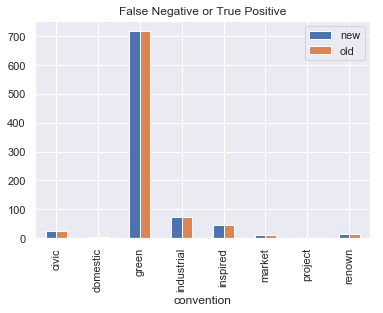

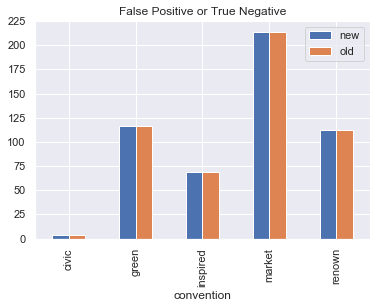

In [121]:
test =  audited_df[['convention', 'new', 'old']].copy()
test[test['new']==1].groupby('convention').count().plot(kind='bar', title="False Negative or True Positive")  
test[test['new']==0].groupby('convention').count().plot(kind='bar', title="False Positive or True Negative") 
test[test['new']==1].groupby('convention').count().plot(kind='bar', title="False Negative or True Positive")  
test[test['new']==0].groupby('convention').count().plot(kind='bar', title="False Positive or True Negative")

In [54]:
print(paths.TRAINING_DATA_DIR_FILE_LOCAL)
print(paths.TRAINING_DATA_DIR_FILE_GIT)
print(paths.TRAINING_DATA_DIR_LOCAL)
print(paths.TRAINING_DATA_DIR_GIT)

Data/Iterative-models-building/Training data/Conventions/training_aggregated_conventions.tsv
cp_wssc/Data/Iterative-models-building/Training data/Conventions/training_aggregated_conventions.tsv
Data/Iterative-models-building/Training data/Conventions/
cp_wssc/Data/Iterative-models-building/Training data/Conventions/


In [37]:
training_files = [f for f in os.listdir(paths.TRAINING_DATA_DIR_LOCAL) if (os.path.isfile(os.path.join(mypath, f)) and "training" in f and not f.startswith( '.' )) and not "random" in f]#[:2]




training_files

NotADirectoryError: [Errno 20] Not a directory: 'Data/Iterative-models-building/Training data/Conventions/training_aggregated_conventions.tsv'

In [ ]:
FEATURES_LENGTH = 3000
VALIDATION_SPLIT = 0.25
GENERATE_NEW_TRAINING_FILES = False

# Get Stopwords
We should also read these directly from github

In [ ]:
stopwords= parsing_helpers.get_stop_words(paths.STOP_WORDS_PATH)

In [ ]:
_conv_ML_models = {}
_test_data_x = {}
_test_data_y = {}


for f in training_files:
    print("----------------------------------------------------------------")
    print("            {}                  ".format(f))
    print("----------------------------------------------------------------")

    
    
    ## USING licensing text from github
    data_train = pd.read_csv(mypath+f, sep='\t')

    #data_train = pd.read_csv('Data/TRAINING_0/training_contributions.txt', sep='\t')

    print(data_train.shape)

    _texts = []
    _labels = []

    for idx in range(data_train.text.shape[0]):
        
        text = [data_train.text[idx]] #BeautifulSoup(data_train.text[idx])
        
        _texts.append(parsing_helpers.clean_str(text))#.encode('ascii','ignore')))
        _labels.append(int(data_train.category[idx]))
        
    #SHUFFLE and DATA SPLITTING 
    x_train, x_val, y_train, y_val = train_test_split(_texts, _labels, test_size=VALIDATION_SPLIT, random_state=42)
    
    _test_data_x[f] = np.array(x_val)[np.where(np.array(y_val)==1)]
    _test_data_y[f] = np.array(y_val)[np.where(np.array(y_val)==1)]
    
    model1 = model_helpers.train_new_text_pipelineNB(x_train, y_train)
    tmp_pred = model1.predict(x_val)
    print("Accuracy: {}".format(np.mean(tmp_pred == y_val)))

    _conv_ML_models[f] = model1
    
    #print("  Naive-Bayes: ",mean1)
    #print("  Random-Forest: ",mean2)
    #print(metrics.classification_report(_labels, pred))
        
    print("\n\n\n")


In [ ]:
#conv_ML_matches = calculate_matches_ML( data_sentences, _conv_ML_models)
conv_ML_matches = model_helpers.calculate_matches_mixture( data_sentences, _conv_ML_models, _conventions_models, _conventions_tokenizers)

In [ ]:
_conv_ML_models['training_Domestic.txt'].predict_proba([data_sentences[0]])

In [ ]:
def get_confidence_value(C):
    return C.confidence_value

In [ ]:
## Conventions results sampling
conv_stratified_classifications = split_sentences_by_confidence(conv_ML_matches, data_sentences, data_sentences_provenance)

for k in conv_stratified_classifications.keys():
    with open(os.path.join(BASE_DIR, "Classification results", CONVS_DIR_NAME, "ML_{}_stratified_classifications.tsv".format(k)), "w")as f3:

        f3.write("{}\t{}\t{}\t{}\n".format("text", "confidence_value", "confidence_level", "data_provenance"))
    
        for c in sorted(conv_stratified_classifications[k],key=get_confidence_value, reverse=True):
            
            f3.write("{}\t{}\t{}\t{}\n".format(c.text, c.confidence_value, c.confidence_level, c.data_provenance))

        f3.close()
    

In [ ]:
conv_stratified_classifications.keys()

In [ ]:
conv_stratified_classifications['training_Civic'],